# Import pakietow 

In [1]:
import numpy as np #Operacje na macierzach
import pandas as pd #Operacje na tabelach
import matplotlib.pyplot as plt #Wizualizacje
import math #Operacje matematyczne
import cv2 #Przetwarzanie obrazow
from glob import glob #Operacje na plikach
import itertools

#Moduly uzywane w glebokim uczeniu sieci neuronowych, uzywane przy przetwarzaniu/analizie obrazu 
#KERAS (umozliwia szybkie eksperymenotowanie na obrazach / uzywane do stworzenia modelu)
#SKLEARN (zapewnia wiele algorytmow do nadzorowania uczenia sieci neuronowych)
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import BatchNormalization
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,CSVLogger

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [2]:
#Zmienne globalne
scale = 70
seed = 7

# Wczytanie danych, obrobka obrazu

In [3]:
images_folder = '../Untitled folder/train/*/*.png'   #podajemy sciezke do danych
images = glob(images_folder)      #odczytujemy dane
trainingset = []
traininglabels = []
images_count = len(images)
count = 1

In [4]:
#Odczytanie obrazow i zmiana rozmiaru
for i in images:
    print(str(count)+'/'+str(images_count),end='\r')  #wyswietla ile obrazkow juz zmieniono
    trainingset.append(cv2.resize(cv2.imread(i),(scale,scale))) #zmieniamy rozmiar obrazka
    traininglabels.append(i.split('/')[-2]) #zmieniamy nazwe obrazu
    count=count+1
trainingset = np.asarray(trainingset)
traininglabels = pd.DataFrame(traininglabels)

## Oczyszczenie obrazow i usuniecia tla
#### * Konwertujemy obraz RGB na HSV.
#### * Będziemy musieli rozmazać obraz, aby usunąć szum.
#### * Będziemy musieli utworzyć maskę, aby usunąć tło.

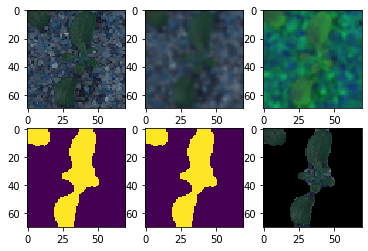

In [5]:
new_train = []
sets = []; getEx = True
for i in trainingset:
    blurr = cv2.GaussianBlur(i,(5,5),0)    #Wygladzanie obrazkow
    hsv = cv2.cvtColor(blurr,cv2.COLOR_BGR2HSV) #Zamiana obrazu z RGB na HVS
    #Parametry dla zieleni:
    lower = (25,40,50)
    upper = (75,255,255)
    
    mask = cv2.inRange(hsv,lower,upper)  #Wyszukanie kolorow (dla naszych parametrow) - zielen
    
    struc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11)) # Zwraca element strukturalny o okreslonym
    #rozmiarze i ksztalcie MORPH_ELLIPSE - czyli wypełniona elipsa wpisana w prostokąt.
    
    mask = cv2.morphologyEx(mask,cv2.MORPH_CLOSE,struc) #przeszktalcenie binarne MORPH_CLOSE - operacja zamykania,\
    #czyli wypelnienie 'dziur', maskuje wystajace elementy.
    boolean = mask>0 #cos jak system 0-1
    new = np.zeros_like(i,np.uint8) #zmiana wartosci logicznych
    new[boolean] = i[boolean]
    new_train.append(new) #'lista' nowych zmienionych obrazkow
    
    if getEx:
        plt.subplot(2,3,1);plt.imshow(i) # Orginalny obrazek
        plt.subplot(2,3,2);plt.imshow(blurr) # Zamazany obrazek
        plt.subplot(2,3,3);plt.imshow(hsv) # Obrazek przekonwertowany do HSV
        plt.subplot(2,3,4);plt.imshow(mask) # Obrazek "zamaskowany"
        plt.subplot(2,3,5);plt.imshow(boolean) # Maska logiczna (boolowska)
        plt.subplot(2,3,6);plt.imshow(new) # Nowy obrazk, oczyszczony, bez tla
        plt.show()
        getEx = False
new_train = np.asarray(new_train)

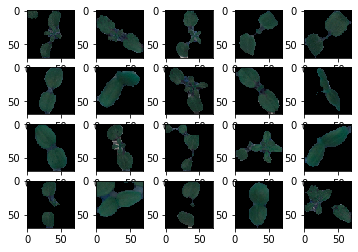

In [6]:
#Oczyszczone obrazy (wyswietlamy tylko 20):
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.imshow(new_train[i]) 

## Konwertowanie etykiet na liczby:

### Etykiety są ciągami i są trudne do przetworzenia. Dlatego przekonwertujemy te etykiety na klasyfikację binarną.
### Klasyfikacja może być reprezentowana przez tablicę 12 liczb, która będzie spełniać warunek:
### * 0 , jeśli gatunek nie zostanie wykryty.
### * 1, jeśli gatunek zostanie wykryty.

In [7]:
labels = preprocessing.LabelEncoder() #normalizacja etykiet
labels.fit(traininglabels[0])  #dopasowanie etykiet
print('Classes'+str(labels.classes_)) #Wypisanie klas
encodedlabels = labels.transform(traininglabels[0]) #przeksztalcenie na znormalizowane etykiety
clearalllabels = np_utils.to_categorical(encodedlabels) #Konwertuje liczby całkowite na binarną macierz klas.
classes = clearalllabels.shape[1]  #Ile mamy klas?
print(str(classes))

Classes['Black-grass' 'Charlock' 'Cleavers' 'Common Chickweed' 'Common wheat'
 'Fat Hen' 'Loose Silky-bent' 'Maize' 'Scentless Mayweed'
 'Shepherds Purse' 'Small-flowered Cranesbill' 'Sugar beet']
12


In [8]:
#Tworzenie tabeli gatunek:ilosc obrazkow
co = pd.DataFrame(traininglabels[0].value_counts()).reset_index().rename(columns={"index": "name", 0: "Count"})
co.Count.sum()

4750

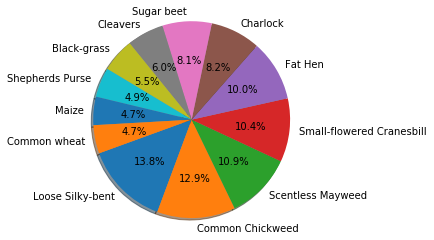

In [9]:
#Tworzenie wykresu
plt.pie(co.Count, labels=co.name, autopct='%1.1f%%', shadow=True, startangle=20000)

plt.axis('equal')
plt.show()

## Definiowanie naszego modelu i dzielenie zestawu danych:

### Musimy wyznaczyc zestaw szkoleniowy do walidacji.

In [23]:
new_train = new_train/255  #bo wartosci pikseli sa do 225.
x_train, x_test, y_train, y_test = train_test_split(new_train,clearalllabels,
                                                 test_size=0.1,random_state=seed,
                                                 stratify=clearalllabels) #podzial tablic na losowe podzbiory

## Zapobieganie przeuczeniu:

### Aby zapobiec nadmiernemu dopasowaniu, musimy stworzyć funkcję, 
### która może losowo zmieniać cechy obrazu podczas dopasowania.

In [25]:
#Tworzenie funkcji powiekszajacej ilosc naszych obrazkow przez powiekszanie, obracanie itd.

generator = ImageDataGenerator(rotation_range = 180, zoom_range = 0.1, width_shift_range = 0.1,
                               height_shift_range = 0.1, horizontal_flip = True, vertical_flip = True)
generator.fit(x_train)

## Definiowanie splotowej sieci neuronowej (CNN):

### Ten model ma 4 warstwy splotu.
### Ten model ma 3 w pełni połączone warstwy.

In [52]:
np.random.seed(seed)

model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(5, 5), input_shape=(scale, scale, 3), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 66, 66, 64)        4864      
_________________________________________________________________
batch_normalization_9 (Batch (None, 66, 66, 64)        256       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 62, 62, 64)        102464    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 31, 31, 64)        256       
_________________________________________________________________
dropout_6 (Dropout)          (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 27, 27, 128)      

In [60]:
model.save('my_model.hdf5')

# Dopasowanie CNN do danych:

In [53]:
#Zmniejszamy tempo uczenia się, gdy wskaźnik przestanie się poprawiać.

lrr = ReduceLROnPlateau(monitor='val_acc', #il monitorowania
                        patience=3,  #liczba epok
                        verbose=1, 
                        factor=0.4, #współczynnik, o który zostanie zmniejszona szybkość uczenia się
                        min_lr=0.00001) #dolna granica szybkości uczenia się.

In [54]:
#Zapisujemy model po każdej epoce.
path = "../Untitiled folder/weights.best_{epoch:02d}-{val_acc:.2f}.hdf5"

checkpoints = ModelCheckpoint(path, monitor='val_acc', 
                              verbose=1, 
                              save_best_only=True, #najnowszy najlepszy model zgodnie z monitorowaną 
                                                    #ilością nie zostanie nadpisany.
                              mode='max')

In [55]:
path = "../Untitiled folder/PlantReco/weights.last_auto4.hdf5"

checkpoints_full = ModelCheckpoint(path, monitor='val_acc', 
                                 verbose=1, save_best_only=False, mode='max')

In [56]:
callbacks_list = [checkpoints, lrr, checkpoints_full]

In [63]:
#Wczytanie modelu

model.load_weights('../Untitled folder/weights.best_17-0.96.hdf5') #Wczytywanie modelu
dataset = np.load("../Untitled folder/Data.npz")  #wczytywanie danych, jako tablice numeryczne

data = dict(zip(("x_train","x_test","y_train", "y_test"), (dataset[k] for k in dataset)))

x_train = data['x_train']
x_test = data['x_test']
y_train = data['y_train']
y_test = data['y_test']

In [34]:
print(model.evaluate(x_train, y_train))  #Zwraca wartość strat i wartości metryk dla modelu w trybie testowym.
print(model.evaluate(x_test, y_test))  #Zwraca wartość strat i wartości metryk dla modelu w trybie treningowym.

4275/4275 [==============================] - 73s 17ms/step
[0.0014230944640479459, 0.999532163143158]
475/475 [==============================] - 8s 17ms/step
[0.2750241681227559, 0.9621052742004395]


## Macierz 'pomyłek':

### Macierz nieporozumień jest jednym z najlepszych sposobów analizy błędów w modelu.
### Podaje dokładną liczbę poprawnych i niepoprawnych prognoz

In [83]:
#Predykcje
y_pred = model.predict(x_test)  #Generuje prognozy wyjściowe dla próbek wejściowych.
y_class = np.argmax(y_pred, axis = 1) 
y_check = np.argmax(y_test, axis = 1) 

#Tworzenie macierzy "pomylek"
cmatrix = confusion_matrix(y_check, y_class)
print(cmatrix)

[[19  0  0  0  0  0  7  0  0  0  0  0]
 [ 0 38  0  0  0  0  0  0  0  1  0  0]
 [ 0  0 28  1  0  0  0  0  0  0  0  0]
 [ 0  0  0 60  0  0  0  0  0  1  0  0]
 [ 0  0  0  0 22  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 47  0  0  0  0  0  0]
 [ 5  0  0  0  0  0 60  0  0  0  0  0]
 [ 0  0  0  0  0  1  0 21  0  0  0  0]
 [ 1  0  0  0  0  0  0  0 51  0  0  0]
 [ 0  0  0  0  0  0  0  0  1 22  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 39]]


In [92]:
all_pred = sum(sum(cmatrix))
all_pred

475

In [93]:
good_pred = np.matrix.trace(cmatrix)
good_pred

457

In [98]:
#Procent dobrych wskazan
power = good_pred/all_pred *100
power

96.21052631578947

# Powtarzamy czynnosci dla zestawu testowego

In [100]:
images_folder = '../Untitled folder/test/*.png'
pics = glob(images_folder)

testimages = []
tests = []
count=1
num = len(pics)

for i in pics:
    print(str(count)+'/'+str(num),end='\r')
    tests.append(i.split('/')[-1])
    testimages.append(cv2.resize(cv2.imread(i),(scale,scale)))
    count = count + 1

testimages = np.asarray(testimages)

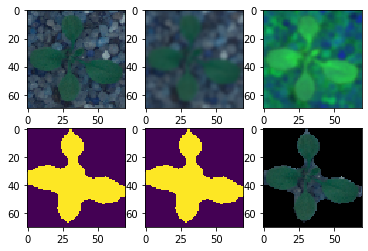

In [101]:
newtestimages = []
sets = []
getEx = True
for i in testimages:
    blurr = cv2.GaussianBlur(i,(5,5),0)
    hsv = cv2.cvtColor(blurr,cv2.COLOR_BGR2HSV)
    
    lower = (25,40,50)
    upper = (75,255,255)
    mask = cv2.inRange(hsv,lower,upper)
    struc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11))
    mask = cv2.morphologyEx(mask,cv2.MORPH_CLOSE,struc)
    boolean = mask>0
    masking = np.zeros_like(i,np.uint8)
    masking[boolean] = i[boolean]
    newtestimages.append(masking)
    
    if getEx:
        plt.subplot(2,3,1);plt.imshow(i)
        plt.subplot(2,3,2);plt.imshow(blurr)
        plt.subplot(2,3,3);plt.imshow(hsv)
        plt.subplot(2,3,4);plt.imshow(mask)
        plt.subplot(2,3,5);plt.imshow(boolean)
        plt.subplot(2,3,6);plt.imshow(masking)
        plt.show()
        getEx=False
newtestimages = np.asarray(newtestimages)

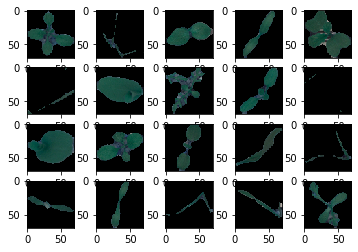

In [102]:
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.imshow(newtestimages[i])

In [103]:
newtestimages=newtestimages/255
prediction = model.predict(newtestimages)

## Tworzenie CSV

In [104]:
pred = np.argmax(prediction,axis=1)
predStr = labels.classes_[pred]  #tworzymy etykiety prognoz
result = {'file':tests,'species':predStr}  #nazwy kolumn : dane
result = pd.DataFrame(result) #tworzenie tabeli
result.to_csv("Prediction.csv",index=False) # 'przetworzenie tabeli na plik csv'

In [105]:
pd.unique(result.species) #Wyswietlenie unikalnych 'nazw' sadzonek z tabeli

array(['Shepherds Purse', 'Black-grass', 'Charlock', 'Sugar beet',
       'Loose Silky-bent', 'Maize', 'Scentless Mayweed',
       'Common Chickweed', 'Cleavers', 'Common wheat', 'Fat Hen',
       'Small-flowered Cranesbill'], dtype=object)

In [106]:
result[:20] 

,file,species
0,1b490196c.png,Shepherds Purse
1,85431c075.png,Black-grass
2,506347cfe.png,Charlock
3,7f46a71db.png,Sugar beet
4,668c1007c.png,Charlock
5,71f5323c5.png,Loose Silky-bent
6,1f3f44563.png,Maize
7,beebe5f4e.png,Scentless Mayweed
8,780defa2e.png,Common Chickweed
9,df521c0c0.png,Loose Silky-bent
